## 0. Import modules and run an example of dummy_gym

2024-11-03 18:49:54.433590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 18:49:56.068435: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2024-11-03 18:49:56.068559: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No su

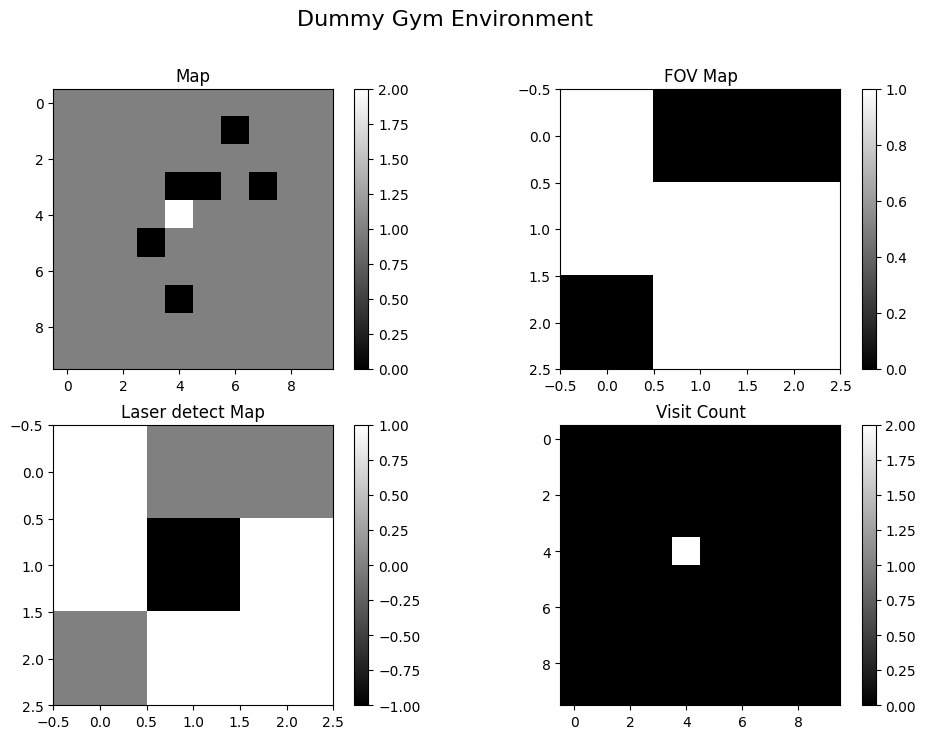

4
Collision! Car stays in the same position:  (4, 4)


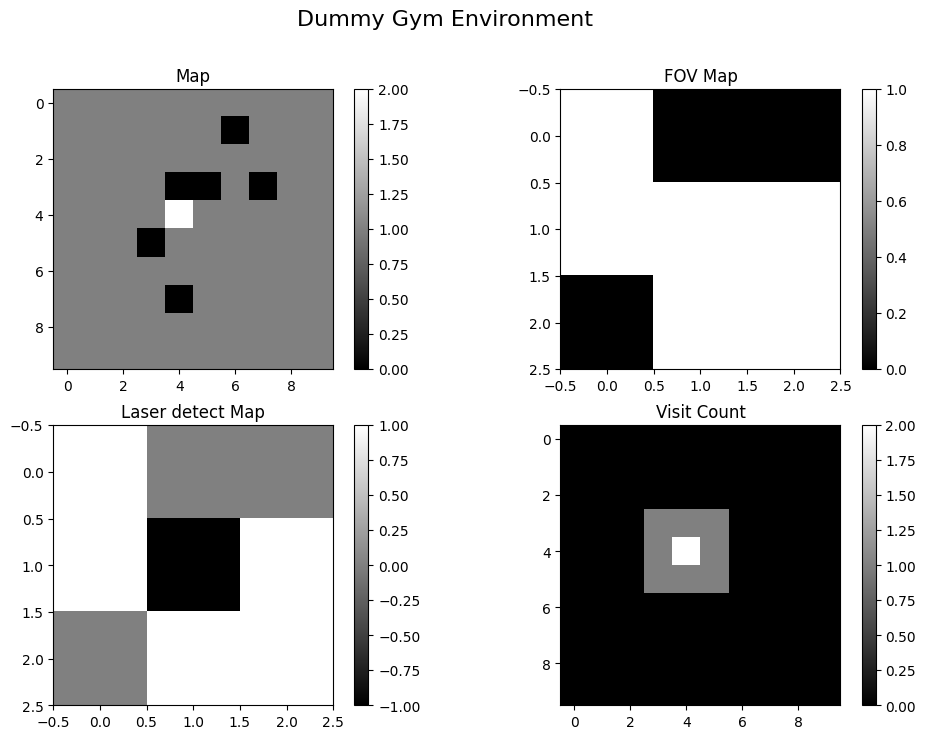

Car moves Left 1 units from (4, 4) to (4, 3)


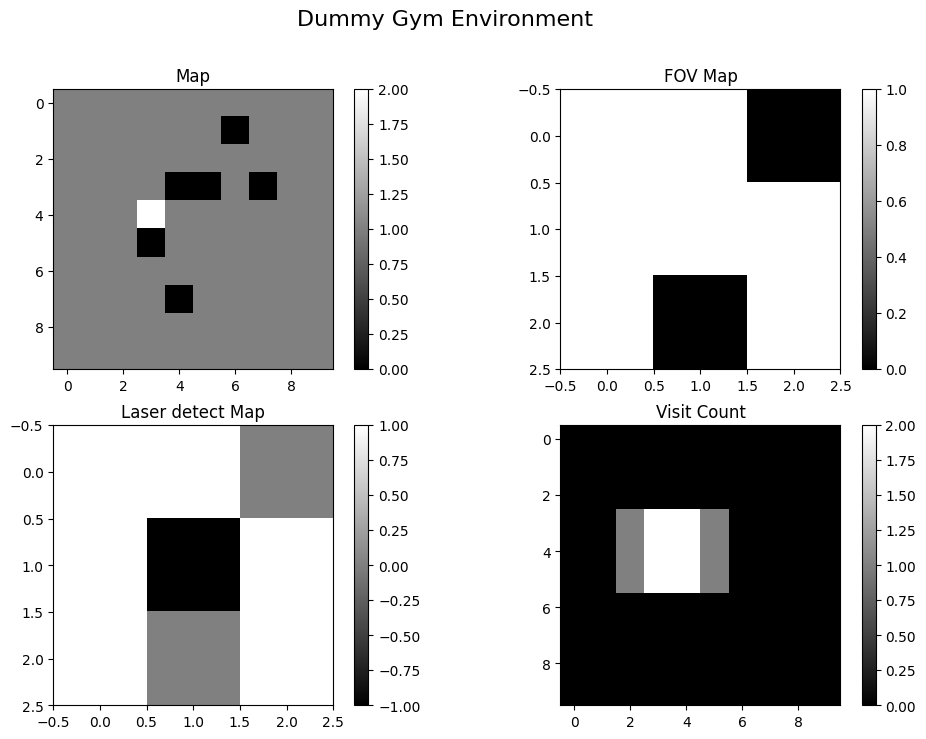

Collision! Car stays in the same position:  (4, 3)


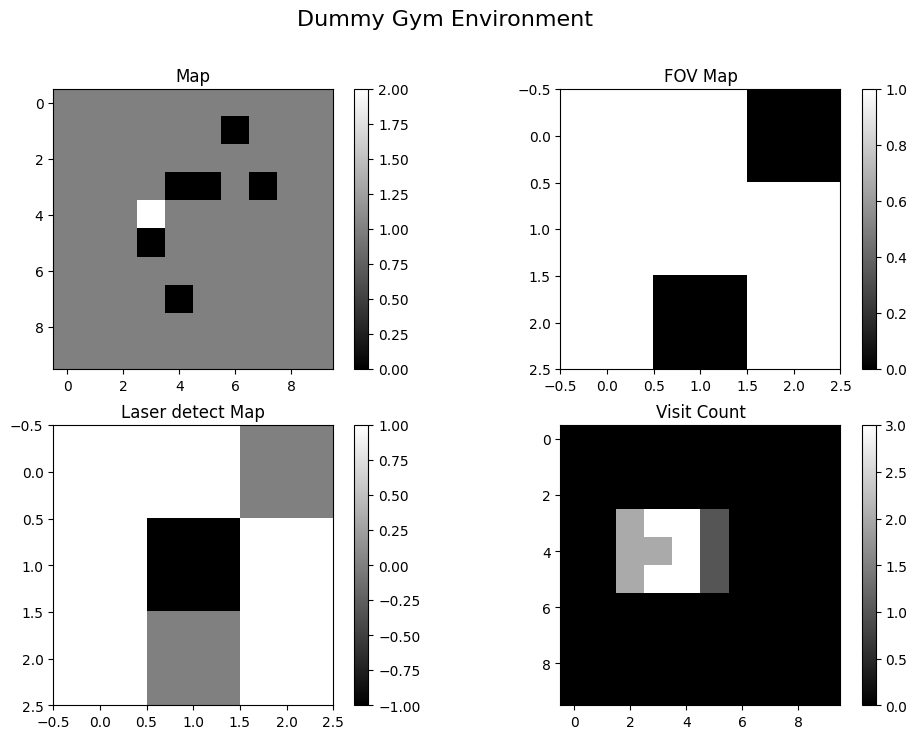

Car moves Right 1 units from (4, 3) to (4, 4)


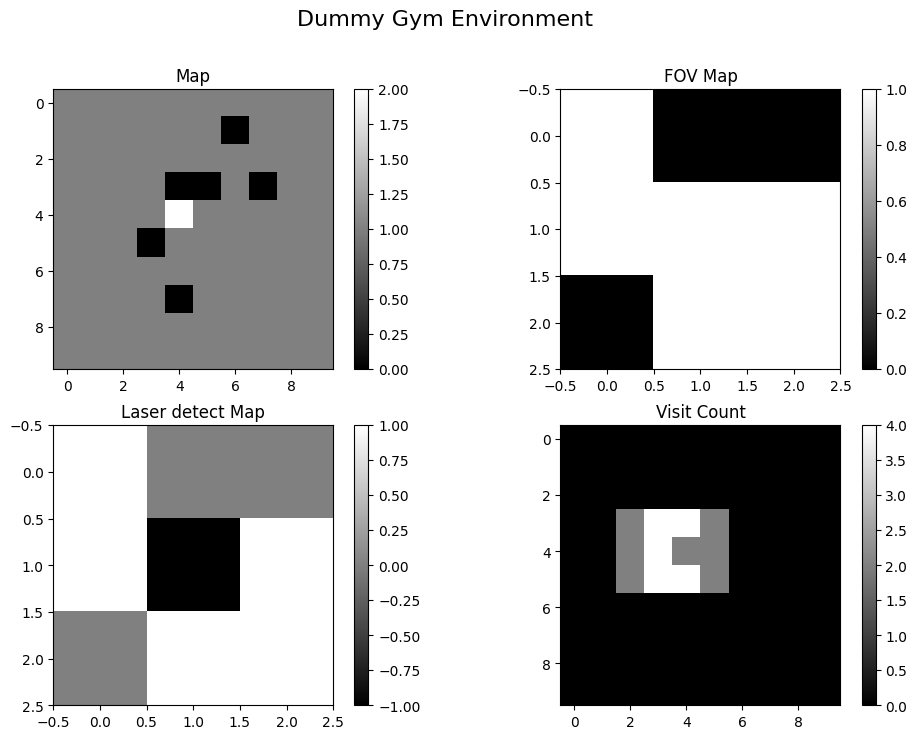

2024-11-03 18:49:59.992783: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-11-03 18:49:59.992809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Legion): /proc/driver/nvidia/version does not exist


In [1]:
# Import the necessary libraries
import tensorflow as tf
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from dummy_gym import DummyGym
import pickle
# from tqdm import tqdm

# if there is a GPU available, set train the device to GPU
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

# Only I need to do this because I am running the code on my local machine
import os
# os.chdir('/home/zhihan/ME5418')

# Create the environment instance
env = DummyGym()


## 1. Parameters setting
In order to test our model, we did not assign large parameters. Set the training mode using one of the following options:
### Training Mode Options
- **`train`**: Start training from scratch, overwriting existing model, state, and replay buffer files.
- **`test`**: Test the model without overwriting any files.
- **`train_from_breakpoint`**: Continue training from the last saved breakpoint.
- **`fine_tune`**: Fine-tune the model while preserving the previous model.

In [16]:
# 断点文件会保存在train_breakpoint文件夹中
# 如果中途训练中断，可以从断点处继续训练，只需将train_mode设置为'train_from_breakpoint'，包括模型文件、状态文件和replay_buffer文件
# 如果想重新训练，将train_mode设置为'train'即可，模型文件、状态文件和replay_buffer文件会被覆盖
# 如果想测试模型，将train_mode设置为'test'即可，模型文件、状态文件和replay_buffer文件不会被覆盖
# 如果既想重新训练，又想保留之前的模型，即微调模型，将train_mode设置为'fine_tune'即可

train_mode = 'train'
# train_mode = 'train' # 'train' or 'test' or 'train_from_breakpoint'
model_name = 'dqn_model.h5'
state_name = 'state.npz'
replay_buffer_name = 'replay_buffer.pkl'

breakpoint_path = 'train_breakpoint'
model_path = os.path.join(breakpoint_path, model_name)
state_path = os.path.join(breakpoint_path, state_name)
replay_buffer_path = os.path.join(breakpoint_path, replay_buffer_name)

# Hyperparameters
original_state = env.observe()
action_size = env.action_space.n
print(f'action_size is {action_size}')
batch_size = 32 # 每次训练的数据量
n_episodes = 1 # 地图数量
time_steps = 3000 # 小车移动次数
epochs = 4 # 每个地图训练次数

# DQN parameters
gamma = 0.99  # discount rate, 0.99 means the future rewards are considered important
epsilon = 0.1  # exploration rate, 0.9 means 90% goes random and 10% goes greedy
epsilon_min = 0.01 # 最小探索率
epsilon_decay = 0.995 # 探索衰减率

# Replay buffer
replay_buffer = deque(maxlen=2000) # 用于存储训练数据


action_size is 4


## 2. Processing states
The state we get from dummy_gym are lists and have only 2 dimensions. So we have to
1. Use `np.array` to change the type of state to `ndarray` for future data processing
2. Use `map.reshape((*map.shape, 1))` to reshape the state to 3 dimensions

In [8]:
# 处理原始state
def prepare_state(original_state):
    '''
    Prepare the state for the model by numpying and adding dimension
    '''
    new_state = []
    new_state_shape = []
    for state in original_state:
        state = np.array(state)
        # add dimension
        state = state.reshape(1, *state.shape, 1) # (30, 30) -> (30, 30, 1)
        new_state.append(state)
        new_state_shape.append(state.shape)

    return new_state, new_state_shape
state, state_shape = prepare_state(original_state)
state_shape[0][1:]

(10, 10, 1)

## 3. Designing out model
After comparing different model output, we found that model behaves best when follows these settings:
1. `pool=True`
2. `dropout=True`
3. `residual=True`
4. `batch_norm=True`
5. `regularizer=None`

You can see the summay of the model in below ceil.\
ps: Different model's outputs are under `dqn_loss_output` file

In [5]:
# class DQN(tf.keras.Model):
#     def __init__(self, state_shape, action_size):
#         super(DQN, self).__init__()
#         self.conv_visit_count_filter = 32
#         self.conv_fov_filter         = 16
#         self.kernel_size             = (3, 3)
#         self.activation              = 'sigmoid'
#         self.pool_size               = (2, 2)
#         self.DoPool                    = True
#         self.DoDropout                 = True
#         self.DoResidual                = True
#         self.DoBatchnorm              = True
#         self.regularizer             = None
#         self.dense_units_1           = 64
#         self.dense_units_2           = 32
#         self.DoDense_twice             = True
#         self.optimizer               = 'adam'
        
#         # Input layers for different state inputs
#         self.input_visit_count = tf.keras.layers.Input(shape=state_shape[0], name='input_visit_count')
#         self.input_fov_map = tf.keras.layers.Input(shape=state_shape[1], name='input_fov_map')
#         self.input_car_pos = tf.keras.layers.Input(shape=state_shape[2], name='input_car_pos')
        
#         self.conv_visit_count = tf.keras.layers.Conv2D(self.conv_visit_count_filter, self.kernel_size, activation=self.activation, padding='same')
#         self.conv_fov_map = tf.keras.layers.Conv2D(self.conv_fov_filter, self.kernel_size, activation=self.activation, padding='same')
        
#         self.batch_norm = tf.keras.layers.BatchNormalization()
#         self.add_residual = tf.keras.layers.Add()
#         self.dropout = tf.keras.layers.Dropout(0.2)
#         self.pool = tf.keras.layers.MaxPooling2D(pool_size=self.pool_size)
#         self.flatten = tf.keras.layers.Flatten()
  
#         # Fully connected layers
#         self.dense1 = tf.keras.layers.Dense(self.dense_units_1, activation=self.activation, kernel_regularizer=self.regularizer)
#         self.dense2 = tf.keras.layers.Dense(self.dense_units_2, activation=self.activation, kernel_regularizer=self.regularizer)
#         self.output_layer = tf.keras.layers.Dense(action_size, activation='linear', kernel_regularizer=self.regularizer)

#         self.build()

#     def build(self):
#         inputs = [self.input_visit_count, self.input_fov_map, self.input_car_pos]
#         self.inputs = inputs
#         # Visit count state branch
#         input_x = self.input_visit_count
#         x = self.conv_visit_count(input_x)
#         x = self.conv_visit_count(x)
#         x = self.batch_norm(x)              if self.DoBatchnorm else x
#         x = self.add_residual([input_x, x]) if self.DoResidual  else x
#         x = self.dropout(x)                 if self.DoDropout   else x
#         x = self.pool(x)                    if self.DoPool      else x
#         x = self.flatten(x)
        
#         # FoV map branch
#         input_y = self.input_fov_map
#         y = self.conv_fov_map(input_y)
#         y = self.conv_fov_map(y)
#         y = self.batch_norm(y)              if self.DoBatchnorm else y
#         y = self.add_residual([input_y, y]) if self.DoResidual  else y
#         y = self.dropout(y)                 if self.DoDropout   else y
#         y = self.pool(y)                    if self.DoPool      else y
#         y = self.flatten(y)
        
#         # Car position branch
#         input_z = self.input_car_pos
#         z = self.flatten(input_z)

#         # Concatenate all branches
#         combined = tf.keras.layers.Concatenate()([x, y, z])

#         # Fully connected layers
#         combined = self.dense1(combined)
#         combined = self.dense2(combined) if self.DoDense_twice else combined
        
#         # Output layer
#         output = self.output_layer(combined)
        
#         self.outputs = output

# model = DQN(state_shape=state_shape, action_size=action_size)
# model.compile(optimizer=model.optimizer, loss='mse')
# model.summary()

In [15]:
def create_dqn_model(conv_filters_1=32, conv_filters_2=16, kernel_size=(3,3), activation='sigmoid', 
                     dense_units_1=64, dense_units_2=32, pool_size=(2,2), 
                     pool=True, dropout=True, residual=True, batch_norm=True, regularizer=None, LSTM=False, flat=True, dense_twice=True): # 多一个全连接多2000参数
                                                                                                                                           # 如果flat=False参数直接减少183万，但会丢失空间信息，因为GlobalAveragePooling2D会平均所有值
    # Input for state_array[0].shape array(120*120)
    input_visit_count_state = tf.keras.layers.Input(shape=state_shape[0][1:], name='input_visit_count_state')
    conv_visit_count_state = tf.keras.layers.Conv2D(conv_filters_1, kernel_size, activation=activation, padding='same')(input_visit_count_state)
    conv_visit_count_state = tf.keras.layers.Conv2D(conv_filters_1, kernel_size, activation=activation, padding='same')(conv_visit_count_state)
    # print(conv_visit_count_state.shape)

    # different settings    
    batch_norm_visit_count_state = tf.keras.layers.BatchNormalization()(conv_visit_count_state) if batch_norm else conv_visit_count_state
    residual_visit_count_state = tf.keras.layers.Add()([input_visit_count_state, batch_norm_visit_count_state])     if residual else batch_norm_visit_count_state
    dropout_visit_count_state  = tf.keras.layers.Dropout(0.2)(residual_visit_count_state)                     if dropout  else residual_visit_count_state
    pool_visit_count_state     = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_visit_count_state) if pool     else dropout_visit_count_state
    
    flat_visit_count_state = tf.keras.layers.Flatten()(pool_visit_count_state) if flat == True else tf.keras.layers.GlobalAveragePooling2D()(pool_visit_count_state)

    # Input for state_array[1].shape 10x10 array
    input_fov_map = tf.keras.layers.Input(shape=state_shape[1][1:], name='input_fov_map')
    conv_fov_map = tf.keras.layers.Conv2D(conv_filters_2, kernel_size, activation=activation, padding='same')(input_fov_map)
    conv_fov_map = tf.keras.layers.Conv2D(conv_filters_2, kernel_size, activation=activation, padding='same')(conv_fov_map)
    # print(conv_fov_map.shape)

    # different settings
    batch_norm_fov_map = tf.keras.layers.BatchNormalization()(conv_fov_map) if batch_norm else conv_fov_map
    residual_fov_map = tf.keras.layers.Add()([input_fov_map, batch_norm_fov_map]) if residual else batch_norm_fov_map
    dropout_fov_map_state = tf.keras.layers.Dropout(0.2)(residual_fov_map) if dropout else residual_fov_map
    pool_fov_map_state = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_fov_map_state) if pool else dropout_fov_map_state
    
    flat_fov_map = tf.keras.layers.Flatten()(pool_fov_map_state) if flat == True else tf.keras.layers.GlobalAveragePooling2D()(pool_fov_map_state)

    # Input for 2x1 array
    input_car_pos = tf.keras.layers.Input(shape=state_shape[2][1:], name='input_car_pos')
    dense_car_pos = tf.keras.layers.Flatten()(input_car_pos)

    # Concatenate all branches
    combined = tf.keras.layers.Concatenate()([flat_visit_count_state, flat_fov_map, dense_car_pos])

    # Add LSTM layer for sequential processing
    lstm_layer = tf.keras.layers.Reshape((1, combined.shape[1]))(combined)  # Reshape for LSTM input
    lstm_layer = tf.keras.layers.LSTM(64, activation=activation)(lstm_layer)  # LSTM layer added

    # Fully connected layers after concatenation
    dense1 = tf.keras.layers.Dense(dense_units_1, activation=activation, kernel_regularizer=regularizer)(lstm_layer if LSTM else combined)
    dense2 = tf.keras.layers.Dense(dense_units_2, activation=activation, kernel_regularizer=regularizer)(dense1) if dense_twice else dense1
    output = tf.keras.layers.Dense(action_size, activation='linear', kernel_regularizer=regularizer)(dense2)

    # Create the model
    model = tf.keras.Model(inputs=[input_visit_count_state, input_fov_map, input_car_pos], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

# Create the DQN model and target model
if train_mode == 'train_from_breakpoint' or train_mode == 'fine_tune':
    model = tf.keras.models.load_model(model_path)
    target_model = tf.keras.models.load_model(model_path)
elif train_mode == 'train' or train_mode == 'test':
    model = create_dqn_model()
    target_model = create_dqn_model()
    target_model.set_weights(model.get_weights())
else:
    raise ValueError('train_mode should be either train, test or train_from_breakpoint')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_visit_count_state (Input  [(None, 10, 10, 1)]  0          []                               
 Layer)                                                                                           
                                                                                                  
 input_fov_map (InputLayer)     [(None, 3, 3, 1)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 10, 10, 32)   320         ['input_visit_count_state[0][0]']
                                                                                                  
 conv2d_2 (Conv2D)              (None, 3, 3, 16)     160         ['input_fov_map[0][0]']      

## 4. Select actions
Actions are selected randomly with the possibility of epsilon. Otherwise will be selected based on `q_values`.

In [4]:
def select_action(state, epsilon):
    '''
    Select action using epsilon-greedy policy
    '''
    if np.random.rand() <= epsilon:
        action = random.randrange(action_size)  # Explore: random action
    else:
        q_values = model.predict(state)  # Exploit: select action with max Q-value
        action = np.argmax(q_values[0])
    
    print(f'Ready to take action:{action}')
    return action  # Exploit: select action with max Q-value


## 5. Define function of trainnign model
1. **Sample a Minibatch**:
   - A minibatch of experiences is randomly sampled from the `replay_buffer` to train the model. Each experience is in the format `(state, action, reward, next_state, done)`.

2. **Loop through each Experience**:
   - The code iterates through each experience in the minibatch to update the model. 

3. **Initialize Target**:
   - The immediate reward is set as the initial target.

4. **Adjust Batch Dimension**:
   - This step ensures that the state tensors have a batch dimension (shape of 4D) by expanding dimensions if needed.

5. **Compute Target if Episode Not Done**:
   - If the episode is not finished (`done` is `False`), the target Q-value is updated using the formula:\
     $
     \text{target} = \text{reward} + \gamma \cdot \max_{a'} Q_{\text{target\_model}}(\text{next\_state}, a')
     $
   - `gamma` is the discount factor that weighs the contribution of future rewards. The target model is used to predict the Q-values of the next state.

6. **Update Predicted Q-Values**:
   - The current state's Q-values are predicted, and the Q-value for the action taken is updated with the calculated target value.

7. **Train the Model**:
   - The model is trained on the current state and updated Q-values for `epochs` iterations. The loss for each training step is stored in `history`.

8. **Plot Loss**:
   - This section plots the loss curve for the training steps within this minibatch.

9. **Update Target Model Weights**:
   - After training, the weights of the target model are updated to match the main model. This helps stabilize training by having a slightly outdated model (target model) to compare predictions.

10. **Return the Losses**:
    - The function returns the loss values for further analysis.

In [5]:
def train_dqn(batch_size):
    with tf.device(device):
        minibatch = random.sample(replay_buffer, batch_size) # Sample minibatch from the replay buffer
        losses = []
        for state, action, reward, next_state, done in minibatch: # 从小批量样本中获取数据
            target = reward # 当前状态的reward作为target
            if not done:
                print(next_state[0].shape)
                target += gamma * np.amax(target_model.predict(next_state)[0]) # 当前状态的reward加上未来最大reward作为target
                # print("target after update:", target)
            
            target_q_values = target_model.predict(state) # 得到4个动作的Q值
            target_q_values[0][action] = target # 将对应动作的Q值更新为target
            history = model.fit(state, target_q_values, epochs=epochs, verbose=0) # 对这个小批量样本训练epochs次,verbose=1表示显示训练进度条
            loss = history.history['loss']
            # plt.plot(loss)
            # plt.xlabel('Epochs')
            # plt.ylabel('Loss')
            # plt.show()

        # Update target model weights
        target_model.set_weights(model.get_weights())
        return losses


## 6. Start tranning!
1. **Initialize Tracking Lists**:
   - These lists store total rewards for each episode and rewards for each time step for tracking and plotting purposes.

2. **Loop Over Episodes**:
   - Iterates through a set number of episodes (`n_episodes`), each representing a complete run of the environment.

3. **Environment Reset**:
   - Resets the environment at the start of each episode and prepares the initial state.

4. **Loop Over Time Steps**:
   - Within each episode, it loops through a maximum number of time steps (`time_steps`), representing agent actions within the environment.

5. **Select and Execute an Action**:
   - Selects an action based on the current policy (using an epsilon-greedy strategy) and takes a step in the environment to obtain the next state, reward, and done flag.

6. **Render and Prepare Next State**:
   - Renders the environment (to visualize changes) and processes the next state for input into the network.

7. **Store Experience**:
   - The current experience `(state, action, reward, next_state, done)` is added to the replay buffer to be used later for training.

8. **Update Rewards**:
   - Adds the reward received at the current time step to the total reward for the episode.

9. **Check if Episode is Complete**:
   - Ends the episode if the `done` flag is set to `True` and prints the episode's result.

10. **Train the Model if Replay Buffer is Large Enough**:
    - If the replay buffer contains enough samples, the DQN model is trained using a batch of experiences.

11. **Store Total Reward and Update Epsilon**:
    - Appends the total reward for the episode to `rewards_list` and decays epsilon to gradually reduce exploration.

Loading model and replay buffer from breakpoint


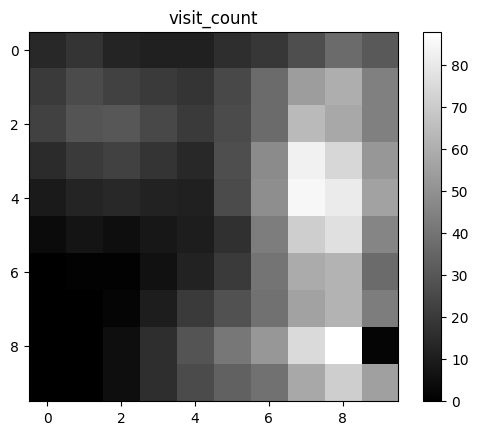

In [6]:
def save_breakpoint():
    model.save(model_path)
    env.save_state(state_path)
    with open(replay_buffer_path, 'wb') as f:
        pickle.dump(replay_buffer, f)

def load_breakpoint():
    # Model already loaded
    with open(replay_buffer_path, 'rb') as f:
        replay_buffer = pickle.load(f)
    env.load_state(state_path)
    return replay_buffer

if train_mode=='train_from_breakpoint':
    replay_buffer = load_breakpoint()
    print('Loading model and replay buffer from breakpoint')
    env.render(map_type='visit_count')


-------------------Time step: 0------------------------
1/1 [==============================] - 0s 94ms/step
Ready to take action:0
Collision! Car stays in the same position:  (4, 4)


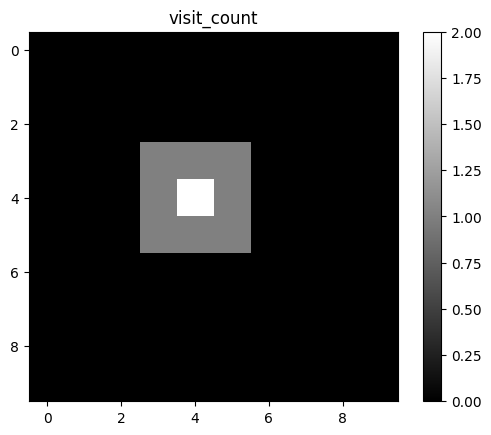

Cells visited: 0/100 at time step: 0
Still adding data to replay buffer. Current replay buffer length: 1

-------------------Time step: 1------------------------
1/1 [==============================] - 0s 18ms/step
Ready to take action:0
Collision! Car stays in the same position:  (4, 4)
Cells visited: 9/100 at time step: 1
Still adding data to replay buffer. Current replay buffer length: 2

-------------------Time step: 2------------------------
1/1 [==============================] - 0s 18ms/step
Ready to take action:0
Collision! Car stays in the same position:  (4, 4)
Cells visited: 9/100 at time step: 2
Still adding data to replay buffer. Current replay buffer length: 3

-------------------Time step: 3------------------------
1/1 [==============================] - 0s 18ms/step
Ready to take action:0
Collision! Car stays in the same position:  (4, 4)
Cells visited: 9/100 at time step: 3
Still adding data to replay buffer. Current replay buffer length: 4

-------------------Time step: 

1/1 [==============================] - 0s 17ms/step
Ready to take action:0
Collision! Car stays in the same position:  (4, 4)
Cells visited: 15/100 at time step: 30
Still adding data to replay buffer. Current replay buffer length: 31

-------------------Time step: 31------------------------
1/1 [==============================] - 0s 19ms/step
Ready to take action:0
Collision! Car stays in the same position:  (4, 4)
Cells visited: 15/100 at time step: 31
Still adding data to replay buffer. Current replay buffer length: 32

-------------------Time step: 32------------------------
1/1 [==============================] - 0s 17ms/step
Ready to take action:0
Collision! Car stays in the same position:  (4, 4)
Cells visited: 15/100 at time step: 32
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 1

(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step

-------------------Time step: 34------------------------
1/1 [==============================] - 0s 14ms/step
Ready to take action:3
Car moves Right 1 units from (4, 5) to (4, 6)
Cells visited: 15/100 at time step: 34
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step

-------------------Time step: 36------------------------
1/1 [==============================] - 0s 15ms/step
Ready to take action:3
Car moves Right 1 units from (4, 7) to (4, 8)
Cells visited: 21/100 at time step: 36
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)


1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step

-------------------Time step: 38------------------------
1/1 [==============================] - 0s 13ms/step
Ready to take action:3
Collision! Car stays in the same position:  (4, 9)
Cells visited: 24/100 at time step: 38
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step

-------------------Time step: 40------------------------
1/1 [==============================] - 0s 14ms/step
Ready to take action:3
Collision! Car stays in the same position:  (4, 9)
Cells visited: 24/100 at time step: 40
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 19ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step

-------------------Time step: 42------------------------
1/1 [==============================] - 0s 16ms/step
Ready to take action:1
Car moves Down 1 units from (4, 9) to (5, 9)
Cells visited: 24/100 at time step: 42
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step

-------------------Time step: 44------------------------
1/1 [==============================] - 0s 15ms/step
Ready to take action:1
Car moves Down 1 units from (5, 8) to (6, 8)
Cells visited: 27/100 at time step: 44
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1

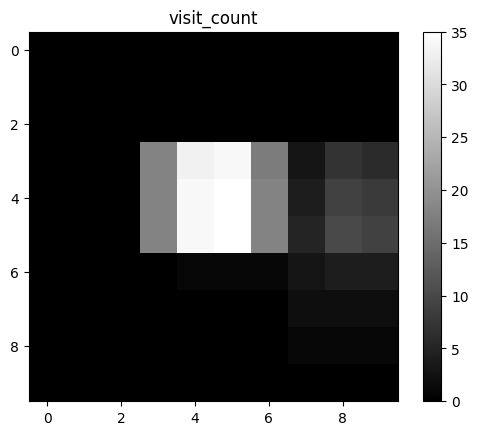

Cells visited: 30/100 at time step: 45
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [=========================

1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

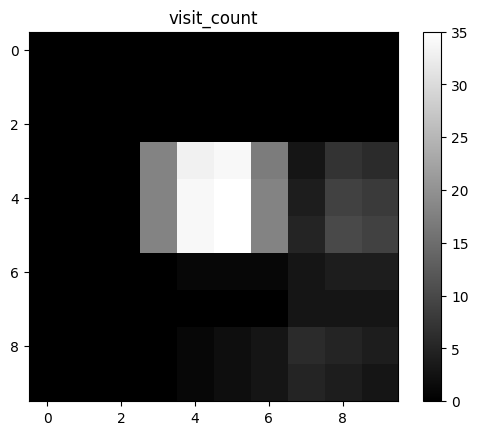

Cells visited: 40/100 at time step: 51
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [=========================

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

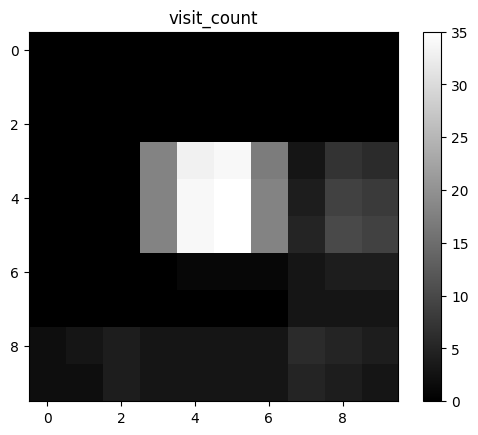

Cells visited: 50/100 at time step: 56
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [=========================

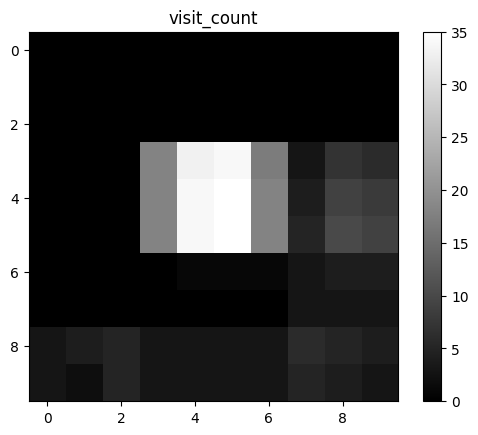

Cells visited: 50/100 at time step: 57
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 19ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [=========================

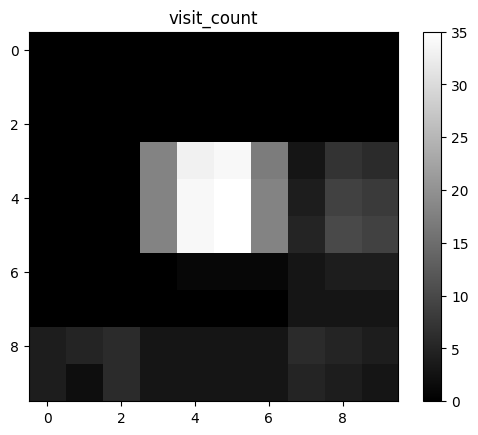

Cells visited: 50/100 at time step: 58
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [=========================

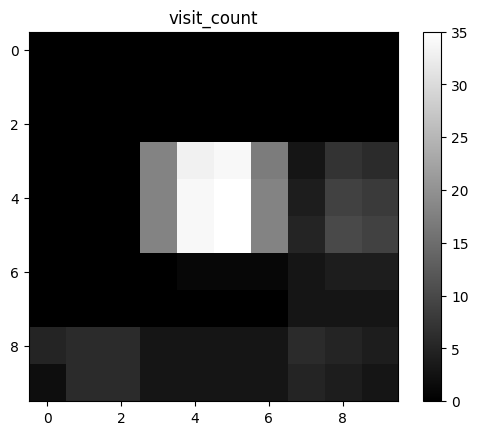

Cells visited: 50/100 at time step: 59
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [=========================

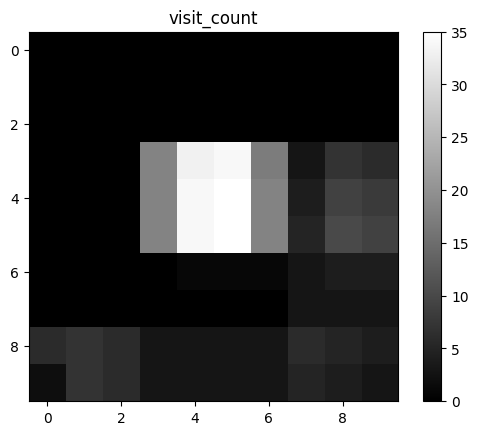

Cells visited: 50/100 at time step: 60
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [=========================

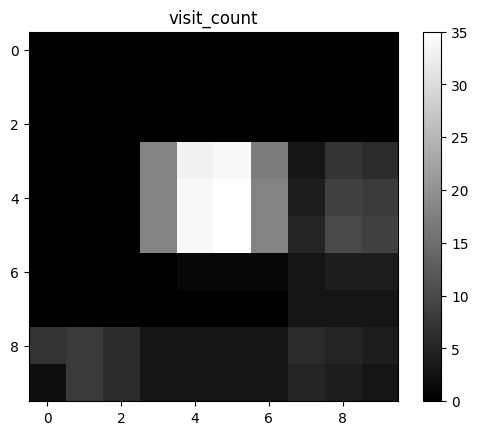

Cells visited: 50/100 at time step: 61
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [=========================

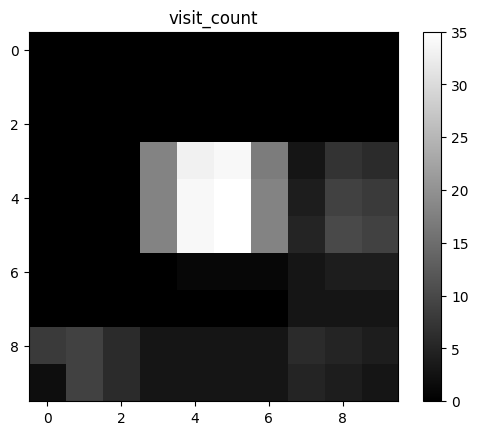

Cells visited: 50/100 at time step: 62
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [=========================

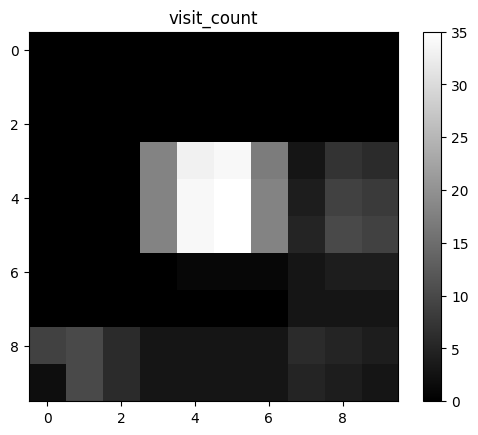

Cells visited: 50/100 at time step: 63
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [=========================

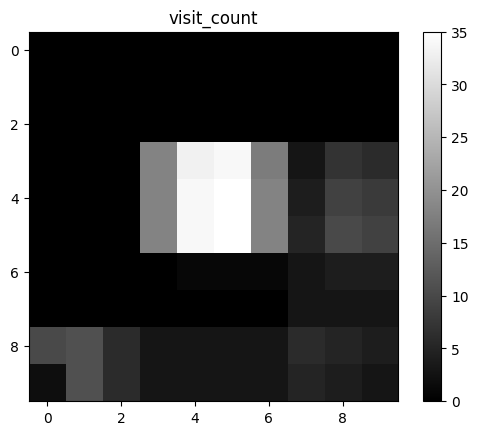

Cells visited: 50/100 at time step: 64
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [=========================

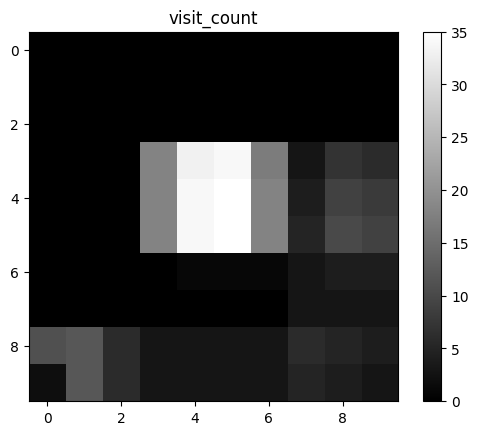

Cells visited: 50/100 at time step: 65
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [=========================

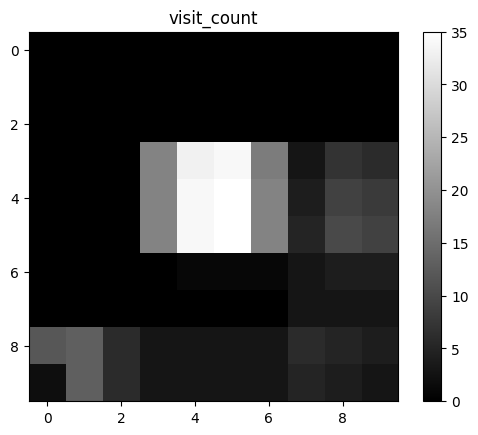

Cells visited: 50/100 at time step: 66
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [=========================

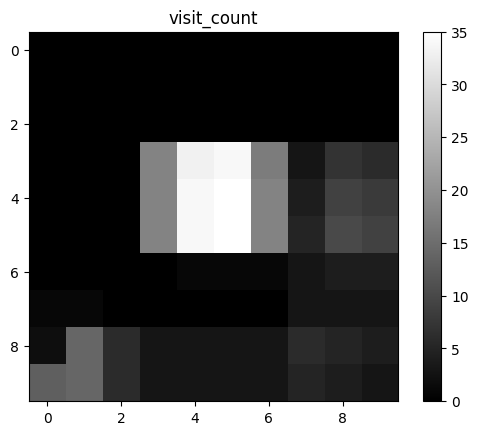

Cells visited: 50/100 at time step: 67
Start training DQN model with batch size: 32
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [=========================

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10

1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 19ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/

1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10

(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10

1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 19ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10

1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 19ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10

1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 19ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 18ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 17ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 16ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10

(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 15ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/

1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 13ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step
(1, 10, 10, 1)
1/1 [==============================] - 0s 14ms/step

---------

In [ ]:
# for episode in range(n_episodes): # 训练多少张图
#     print(f"\n********************Episode: {episode+1}/{n_episodes}********************")
state = env.state if train_mode== 'train_from_breakpoint' else env.reset()
# state = env.reset()
state,_ = prepare_state(state)
time_step = 0

# for time_step in range(time_steps):  # 每张图训练小车走至多多少步

while True: 
    print(f"\n-------------------Time step: {time_step}------------------------")

    # In each time step, agent selects an action and implement it, environment provides feedback
    action = select_action(state, epsilon) # 选择动作，有bug
    next_state, reward, done, _ = env.step(action)
    if done:
        env.render(map_type="visit_count")
        print("This eqisode is done, ready for next one.")
        break

    cells_visited = state[0][state[0] > 0].shape[0] # 计算已经访问的cell数量
    cells = env.map_size[0]*env.map_size[1]
    env.render(map_type="visit_count") if cells_visited % (cells/10) == 0 else None
    print(f"Cells visited: {cells_visited}/{env.map_size[0]*env.map_size[1]} at time step: {time_step}")

    # Store the data into replay buffer
    next_state,_ = prepare_state(next_state)
    replay_buffer.append((state, action, reward, next_state, done)) # 将数据存入replay buffer

    # Update state
    state = next_state

    # Train the model when replay buffer is larger than batch size
    if len(replay_buffer) > batch_size: # 当步数大于batch size时开始训练
        print(f"Start training DQN model with batch size: {batch_size}")
        losses = train_dqn(batch_size)

        # Decay epsilon after 50 training steps
        if time_step % 50 == 0 and epsilon > epsilon_min:
            epsilon *= epsilon_decay
            print(f"Decayed epsilon: {epsilon}")

        # If we are in train mode, save the gym, model and replay buffer for emergency stop every 100 time steps
        if train_mode == 'train' or train_mode == 'train_from_breakpoint' and time_step % 100 == 0:
            save_breakpoint()
            print(f"Saved model and replay buffer at time step: {time_step}")
    
    # Otherwise, keep adding data to replay buffer
    else:
        print(f"Still adding data to replay buffer. Current replay buffer length: {len(replay_buffer)}")
    
    time_step += 1
